In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cuhk03/pairs.csv
/kaggle/input/cuhk03/archive/splits_classic_labeled.json
/kaggle/input/cuhk03/archive/splits_new_detected.json
/kaggle/input/cuhk03/archive/splits_new_labeled.json
/kaggle/input/cuhk03/archive/cuhk03_new_protocol_config_detected.mat
/kaggle/input/cuhk03/archive/cuhk03_new_protocol_config_labeled.mat
/kaggle/input/cuhk03/archive/splits_classic_detected.json
/kaggle/input/cuhk03/archive/cuhk03_release/cuhk-03.mat
/kaggle/input/cuhk03/archive/cuhk03_release/README.md
/kaggle/input/cuhk03/archive/images_labeled/1_214_2_10.png
/kaggle/input/cuhk03/archive/images_labeled/1_254_1_02.png
/kaggle/input/cuhk03/archive/images_labeled/1_079_2_06.png
/kaggle/input/cuhk03/archive/images_labeled/2_278_1_04.png
/kaggle/input/cuhk03/archive/images_labeled/2_136_1_01.png
/kaggle/input/cuhk03/archive/images_labeled/1_627_2_06.png
/kaggle/input/cuhk03/archive/images_labeled/1_798_2_06.png
/kaggle/input/cuhk03/archive/images_labeled/4_043_2_10.png
/kaggle/input/cuhk03/archive

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import cv2
import torch.nn.functional as F
from PIL import Image
from glob import glob
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [16]:
train_path = "../input/cuhk03/archive/images_labeled/"
size = (160, 60)

In [21]:
class MyDataset(Dataset):
    def __init__(self, data, path, transform=None):
        self.data = data
        self.path = path
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img1 = Image.open(train_path + self.data["image1"][idx])
        img2 = Image.open(train_path + self.data["image2"][idx])
        if torch.cuda.is_available():
            img1.to("cuda")
            img2.to("cuda")
        label = self.data["label"][idx]
        
        # Apply image transformations
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        
        return img1, img2, label

In [22]:
train_data = pd.read_csv("../input/cuhk03/pairs.csv")[:400]
resize = transform=transforms.Compose([transforms.Resize(size),
                                       transforms.ToTensor()
                                     ])

train_dataset = MyDataset(train_data, train_path, transform=resize)

In [23]:
def display_image_pair(img1, img2, label):
    fig, axes = plt.subplots(1,2)
    axes[0].imshow(np.transpose(img1.numpy(), (1, 2, 0)))
    axes[1].imshow(np.transpose(img2.numpy(), (1, 2, 0)))
    if label:
        fig.suptitle('Detected', y=1)
    else:
        fig.suptitle('not detected', y=1)

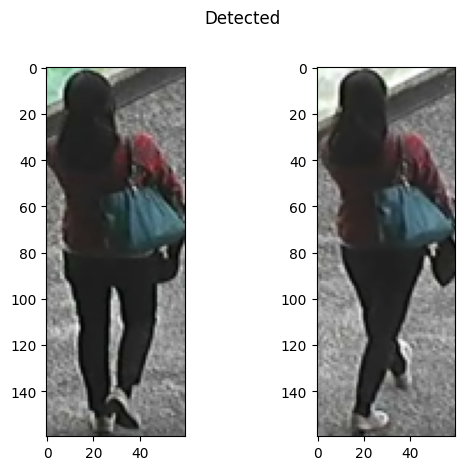

In [24]:
img1, img2, label = train_dataset[324]
display_image_pair(img1, img2, label)

In [25]:
train_dataset[0][2]

1

In [27]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
    
        self.extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5,stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(in_channels=10, out_channels=15, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.patch = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=20, kernel_size=5, stride=5),
            nn.ReLU(inplace=True)
        )
        
        self.across_patch = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=25, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.relu = nn.ReLU()
        
        self.fc = nn.Sequential(
            
            nn.Linear(4500, 10),
            nn.ReLU(inplace=True),
            
            nn.Linear(10,2)
        )
        
        self.pad = nn.ZeroPad2d(2)
        
        self.softmax = nn.Softmax()
       
    def get_f(self, f):
        _, _, h, w = f.size()
        f = nn.functional.interpolate(f, mode='nearest', size=(h * 5, w * 5))
        f = torch.squeeze(f)
        return f
    
    def get_g(self, y):
        b, c, h, w = y.size()
        g = torch.zeros((b, c, h * 5, w * 5))
        y = self.pad(y)
        for i in range(h):
            for j in range(w):
                a = i*5
                b = j*5
                g[:,:,a:a+5, b:b+5] = y[:,:,i:i+5,j:j+5]
        return g
         
    def cross_input_neighbourhood_difference(self, y1, y2):
        f = self.get_f(y1)
        g = self.get_g(y2)
        return self.relu(f - g)
        
    def forward(self, img1, img2):
        y1 = torch.tensor(img1).float()
        y2 = torch.tensor(img2).float()
        
        y1 = torch.squeeze(y1)
        y2 = torch.squeeze(y2)
        
        y1 = self.extractor(y1)
        y2 = self.extractor(y2)
        
        y1_2 = self.cross_input_neighbourhood_difference(y1, y2)
        y2_1 = self.cross_input_neighbourhood_difference(y2, y1)
    
        y1 = self.patch(y1_2)
        y1 = self.across_patch(y1)
        y2 = self.patch(y2_1)
        y2 = self.across_patch(y2)
        
        y = torch.hstack((y1, y2))
        
        b = y.shape[0]
        y = y.reshape( (b, -1))
        y = self.fc(y)
        
        y = self.softmax(y)
        
        return y

In [28]:
model = SiameseNetwork()
if torch.cuda.is_available():
    model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 20
batch_size = 2048
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

In [29]:

def train():
    
    loss_history = [] 
    
    for epoch in range(epochs):
        for i, data in enumerate(train_dataloader, 0):
            img1, img2 , label = data
            
            optimizer.zero_grad()
            y = model(img1, img2)
            loss = criterion(y, label)
            loss.backward()
            optimizer.step()
            
            if i % 5 == 0:
                print(f"Epoch number {epoch}\n Current loss {loss.item()} \n\n")
                loss_history.append(loss.item())
    return loss_history

In [30]:
history = train()

/tmp/ipykernel_32/1079277044.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y1 = torch.tensor(img1).float()
/tmp/ipykernel_32/1079277044.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y2 = torch.tensor(img2).float()
/tmp/ipykernel_32/1079277044.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y = self.softmax(y)


Epoch number 0
 Current loss 0.7316637635231018 


Epoch number 1
 Current loss 0.7195573449134827 


Epoch number 2
 Current loss 0.7068042159080505 


Epoch number 3
 Current loss 0.6879395842552185 


Epoch number 4
 Current loss 0.6596584320068359 


Epoch number 5
 Current loss 0.6171585917472839 


Epoch number 6
 Current loss 0.5580244660377502 


Epoch number 7
 Current loss 0.49117758870124817 


Epoch number 8
 Current loss 0.4408172369003296 


Epoch number 9
 Current loss 0.4214901030063629 


Epoch number 10
 Current loss 0.41845932602882385 


Epoch number 11
 Current loss 0.41826722025871277 


Epoch number 12
 Current loss 0.41826170682907104 


Epoch number 13
 Current loss 0.4182616174221039 


Epoch number 14
 Current loss 0.41826164722442627 


Epoch number 15
 Current loss 0.4182615578174591 


Epoch number 16
 Current loss 0.4182616174221039 


Epoch number 17
 Current loss 0.4182615578174591 


Epoch number 18
 Current loss 0.4182616174221039 


Epoch number 19
 

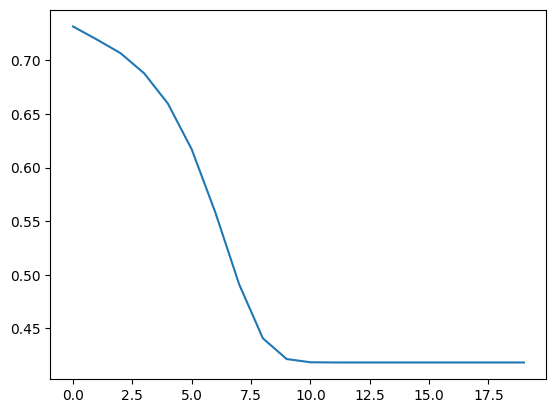

In [32]:
plt.plot(history)

In [42]:

# from sklearn.metrics import precision_score, recall_score
from torchmetrics.classification import Precision, Recall

predictions = []
targets = []
model.eval()
for i, data in enumerate(train_dataloader, 0):
    
    img1, img2 , label = data
    with torch.no_grad():
            y = model(img1, img2)
            predictions.append(y)
            targets.append(label)


predictions = torch.cat(predictions)
targets = torch.cat(targets)

precision = Precision(task="multiclass", average='macro', num_classes=2)(predictions, targets)
recall = Recall(task="multiclass", average='macro', num_classes=2)(predictions, targets)



/tmp/ipykernel_32/1079277044.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y1 = torch.tensor(img1).float()
/tmp/ipykernel_32/1079277044.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y2 = torch.tensor(img2).float()
/tmp/ipykernel_32/1079277044.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y = self.softmax(y)
